# Water Change
<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/vF_Water%20Change.png" />
[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)
This product enables the change in surface area of water between two time periods to be detected.

In [1]:
# jupyteronly
%matplotlib inline
import datacube
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from matplotlib.cm import RdYlGn, Greens
from datacube_utilities.interactive_maps import display_map

### Import required modules

In [2]:
import numpy as np
import xarray as xr
from pyproj import Proj, transform

from datacube.storage import masking
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube.utils.cog import write_cog


import dask
from dask.distributed import Client

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/distributed/client.py:1138: VersionMismatchWarning: Mismatched versions found

+-------------+--------+-----------+---------+
| Package     | client | scheduler | workers |
+-------------+--------+-----------+---------+
| blosc       | 1.9.1  | 1.10.2    | 1.10.2  |
| cloudpickle | 1.5.0  | 2.0.0     | 2.0.0   |
| distributed | 2.24.0 | 2.30.1    | 2.30.1  |
| lz4         | 3.1.0  | 3.1.1     | 3.1.1   |
| msgpack     | 1.0.0  | 0.6.1     | 0.6.1   |
| numpy       | 1.18.1 | 1.18.5    | 1.18.5  |
| tornado     | 6.0.4  | 6.0.3     | 6.0.3   |
+-------------+--------+-----------+---------+
Notes: 
-  msgpack: Variation is ok, as long as everything is above 0.6
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
/opt/conda/

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


## Initialise

In [3]:
# jupyteronly
dc = datacube.Datacube(app='water-change')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:
# parameters

#area of interest: load in as wkt
#parameter display_name="Area of Interest" description="The area for which the product is required." datatype="wkt",
aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#set start and end dates for time period of interest
#parameter display_name="Baseline Start Date" description='Start of the baseline time period window' datatype="date"
baseline_time_start = '1990-3-1'
#parameter display_name="Baseline End Date" description='End of the baseline time period window' datatype="date"
baseline_time_end = '1995-9-1'

#set start and end dates for time period of interest
#parameter display_name="Analysis Start Date" description='Start of the analysis time period window' datatype="date"
analysis_time_start = '1993-3-1'
#parameter display_name="Analysis End Date" description='End of the analysis time period window' datatype="date"
analysis_time_end = '1995-9-1'

#set resolution
#parameter display_name="Resolution (m)" description="Size of pixels" datatype="int"
res = (30)

#choose sensor
#parameter display_name="Baseline Sensor" description="Satellite to use for baseline time period, more than one can be selected." datatype="multi" options=["sentinel_2", "landsat_4", "landsat_5", "landsat_7", "landsat_8", "sentinel_1"],
#baseline_platform = ["landsat_8", "sentinel_2"]
baseline_platform = ["landsat_5", "landsat_4"]

#choose sensor
#parameter display_name="Analysis Sensor" description="Satellite to use for analysis time period, more than one can be selected." datatype="multi" options=["sentinel_2", "landsat_4", "landsat_5", "landsat_7", "landsat_8", "sentinel_1"],
#analysis_platform = ["landsat_8", "sentinel_2"]
analysis_platform = ["landsat_5", "landsat_4"]


#parameter display_name="Coordinate Reference System" description="The EPSG code for the CRS, for Fiji this will be 3460." datatype="string" options=["3460", "3832"],
crs = "3460"

#this parameter should be restricted to between 1 and 100, should not be valid for landsat4 and landsat5
#parameter display_name="Percentage Confidence" description="The level of confidence acceptable for an individual pixel, recommended to start with 5%" datatype="int", options=[0,100]
confidenceLevel = (5)

#parameter which determines what water threshold we accept as being water. Restrict to be between 0 and 1. 
#parameter display_name="Water Threshold" description="The value for how strict the water masking should be, ranging from 0 for always land and 1 for always water." datatype="float" options=[0,1]
waterThresh = 0.3


### Reformat Parameters

In [5]:
#get latitude and longitude
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [6]:
# jupyteronly
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [7]:
#reprojection of AOI into input CRS and reformat
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:"+crs)
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/envs/cubeenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  
/

(3934260.914984402, 3945633.577378467)
(1880642.0275783802, 1896308.818778341)


In [8]:
productDict = {"sentinel_2":"sentinel_2_mlwater", 
    "sentinel_1": "sentinel_1_mlwater",
    "landsat_8": "landsat_8_mlwater",
    "landsat_7": "landsat_7_mlwater",
    "landsat_5": "landsat_5_mlwater",
    "landsat_4": "landsat_4_wofs",
}

def getWaterProduct(platform):
    return [productDict[i] for i in platform]

In [9]:
#get names of desired water products
baseline_water_product = getWaterProduct(baseline_platform)
print(baseline_water_product)

analysis_water_product = getWaterProduct(analysis_platform)
print(analysis_water_product)

['landsat_5_mlwater', 'landsat_4_wofs']
['landsat_5_mlwater', 'landsat_4_wofs']


In [10]:
#create resolution
resolution = (-res, res)

In [11]:
dask_chunks = dict(
    time = 1,
    x = 2000,
    y = 2000
)

In [12]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_time_start, baseline_time_end)
analysis_time_period = createDate(analysis_time_start, analysis_time_end)


## Load Data 

In [13]:
#generic for load query
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': "EPSG:"+crs,
    'resolution': resolution,
    'dask_chunks': dask_chunks,
    'crs': "EPSG:"+crs
}

In [14]:
#function to check if datasets are empty
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

### Load in water masks

#go through dataset list and load those which have data based on the query. 
def loadWaterMask(productList, time_period):
    #print(productList)
    product_data = []
    print(productList)
    for productInput in productList:
        if productInput in ["s2_water_mlclassification", "s1_water_mlclassification", "ls8_water_mlclassification", "ls7_water_mlclassification"]:
            print(productInput)
            water_scenes = dc.load(product=productInput,
                  measurements = ["watermask", "waterprob"],
                                   time = time_period,
                   **query)
            #print(productInput)
            #print(water_scenes)
            if is_dataset_empty(water_scenes):
                print(productInput, 'is empty')
            #change clouds to no data value
            else:
                water_classes = water_scenes.where(water_scenes >= 0)
                good_quality_water = (
                   (water_scenes.watermask >= 0) & # no data
                    (
                     (water_scenes.waterprob <= confidenceLevel) |
                        (water_scenes.waterprob >= 100-confidenceLevel)
                    )
                    )
                water_classes = water_scenes.where(good_quality_water)
                water_classes['waterprob'] = (100-water_classes['waterprob']) # assign nodata vals consistent w/ other prods
                product_data.append(water_classes)
        elif productInput in ["ls5_water_classification", "ls4_water_classification"]:
            water_scenes = dc.load(product=productInput,
                                   measurements = ["water"],
                                   time = time_period,
                                       **query)
            if is_dataset_empty(water_scenes):
                print(productInput, 'is empty')
            else:
                water_classes1 = water_scenes.where(water_scenes != -9999)
                water_classes1['watermask'] = water_classes1['water']
                water_classes = water_classes1.drop(['water'])
                product_data.append(water_classes)
        else:
            print('invalid platform')
    return product_data



In [30]:
#go through dataset list and load those which have data based on the query. 
def loadWaterMask(productList, time_period):
    #print(productList)
    product_data = []
    print(productList)
    for productInput in productList:
        print(productInput)
        print('next')
        if productInput in ["sentinel_2_mlwater", "sentinel_1_mlwater", "landsat_8_mlwater", "landsat_7_mlwater", "landsat_5_mlwater"]:
            print(productInput)
            water_scenes = dc.load(product=productInput,
                  measurements = ["water_ml", "waterprob_ml"],
                                   time = time_period,
                   **query)
            #print(productInput)
            #print(water_scenes)
            if is_dataset_empty(water_scenes):
                print(productInput, 'is empty')
            #change clouds to no data value
            else:
                water_classes = water_scenes.where(water_scenes >= 0)
                good_quality_water = (
                   (water_scenes.water_ml >= 0) & # no data
                    (
                     (water_scenes.waterprob_ml <= confidenceLevel) |
                        (water_scenes.waterprob_ml >= 100-confidenceLevel)
                    )
                    )
                water_classes = water_scenes.where(good_quality_water)
                water_classes['waterprob_ml'] = (100-water_classes['waterprob_ml']) # assign nodata vals consistent w/ other prods
                water_classes = water_classes.drop(['waterprob_ml'])
                product_data.append(water_classes)
        elif productInput in ["landsat_4_wofs"]:
            water_scenes = dc.load(product=productInput,
                                   measurements = ["water_wofs"],
                                   time = time_period,
                                       **query)
            if is_dataset_empty(water_scenes):
                print(productInput, 'is empty')
            else:
                water_classes1 = water_scenes.where(water_scenes != -9999)
                water_classes1['water_ml'] = water_classes1['water_wofs']
                water_classes = water_classes1.drop(['water_wofs'])
                product_data.append(water_classes)
        else:
            print('invalid platform')
    return product_data

In [31]:
#baseline_water_product = ["ls8_water_mlclassification", "ls8_water_mlclassification" ]
# "s2_water_mlclassification"

In [32]:
#print(baseline_water_product)

In [33]:
print(baseline_water_product)

['landsat_5_mlwater', 'landsat_4_wofs']


In [34]:
waterclass_baseline = loadWaterMask(baseline_water_product, baseline_time_period)
wc_baseline = xr.concat(waterclass_baseline, dim='time').sortby('time')
wc_baseline.nbytes/1000000000, wc_baseline

['landsat_5_mlwater', 'landsat_4_wofs']
landsat_5_mlwater
next
landsat_5_mlwater
landsat_4_wofs
next


(0.063604348,
 <xarray.Dataset>
 Dimensions:      (time: 40, x: 523, y: 380)
 Coordinates:
     spatial_ref  int32 3460
   * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
   * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06
   * time         (time) datetime64[ns] 1990-12-06 1991-01-23 ... 1993-03-25
 Data variables:
     water_ml     (time, y, x) float64 dask.array<chunksize=(1, 380, 523), meta=np.ndarray>
 Attributes:
     crs:           EPSG:3460
     grid_mapping:  spatial_ref)

In [35]:
print(wc_baseline)

<xarray.Dataset>
Dimensions:      (time: 40, x: 523, y: 380)
Coordinates:
    spatial_ref  int32 3460
  * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
  * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06
  * time         (time) datetime64[ns] 1990-12-06 1991-01-23 ... 1993-03-25
Data variables:
    water_ml     (time, y, x) float64 dask.array<chunksize=(1, 380, 523), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref


In [36]:
waterclass_analysis = loadWaterMask(analysis_water_product, analysis_time_period)
wc_analysis = xr.concat(waterclass_analysis, dim='time').sortby('time')
wc_analysis.nbytes/1000000000, wc_analysis

['landsat_5_mlwater', 'landsat_4_wofs']
landsat_5_mlwater
next
landsat_5_mlwater
landsat_5_mlwater is empty
landsat_4_wofs
next


(0.003187084,
 <xarray.Dataset>
 Dimensions:      (time: 2, x: 523, y: 380)
 Coordinates:
     spatial_ref  int32 3460
   * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
   * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06
   * time         (time) datetime64[ns] 1993-03-09 1993-03-25
 Data variables:
     water_ml     (time, y, x) float64 dask.array<chunksize=(1, 380, 523), meta=np.ndarray>
 Attributes:
     crs:           EPSG:3460
     grid_mapping:  spatial_ref)

## Create mosaic of water mask

In [37]:
wc_baseline_mean = wc_baseline.water_ml.mean(dim='time')
wc_baseline_mean 

<xarray.DataArray 'water_ml' (y: 380, x: 523)>
dask.array<mean_agg-aggregate, shape=(380, 523), dtype=float64, chunksize=(380, 523), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3460
  * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
  * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06

In [38]:
wc_analysis_mean = wc_analysis.water_ml.mean(dim='time')
wc_analysis_mean

<xarray.DataArray 'water_ml' (y: 380, x: 523)>
dask.array<mean_agg-aggregate, shape=(380, 523), dtype=float64, chunksize=(380, 523), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3460
  * y            (y) float64 3.946e+06 3.946e+06 ... 3.934e+06 3.934e+06
  * x            (x) float64 1.881e+06 1.881e+06 ... 1.896e+06 1.896e+06

In [39]:
#fig, ax = plt.subplots(figsize=(50,50))
#ax.imshow(wc_baseline_mean)

In [40]:
#fig, ax = plt.subplots(figsize=(50,50))
#ax.imshow(wc_analysis_mean)

In [41]:
#water_pc = (landsat_resampled_prob*100).where((landsat_resampled_prob == False),-9999) # assign nodata vals consistent w/ other prods

### Make difference range product

In [42]:
###This is the second output we want.
difference_range = (wc_analysis_mean - wc_baseline_mean)

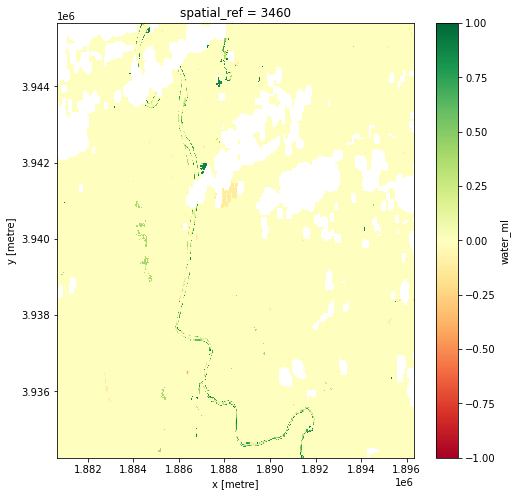

In [43]:
# jupyteronly
difference_range = difference_range.compute()
plt.figure(figsize = (8,8))
difference_range.plot(vmin=-1, vmax=1, cmap=RdYlGn)

### Make threshold difference product

In [44]:
%%time
T0_nd_water = np.isnan(wc_baseline_mean)
wc_baseline_rc_int = wc_baseline_mean.where((wc_baseline_mean < waterThresh) | (T0_nd_water == True), 1) # fix > prob to water
wc_baseline_rc = wc_baseline_rc_int.where((wc_baseline_rc_int >= waterThresh) | (T0_nd_water == True), 0) # fix < prob to no water

CPU times: user 21.3 ms, sys: 142 µs, total: 21.5 ms
Wall time: 23.6 ms


In [45]:
%%time
T1_nd_water = np.isnan(wc_analysis_mean)
wc_analysis_rc_int = wc_analysis_mean.where((wc_analysis_mean < waterThresh) | (T1_nd_water == True), 1) # fix > prob to water
wc_analysis_rc = wc_analysis_rc_int.where((wc_analysis_rc_int >= waterThresh) | (T1_nd_water == True), 0) # fix < prob to no water

CPU times: user 20.6 ms, sys: 69 µs, total: 20.7 ms
Wall time: 20.4 ms


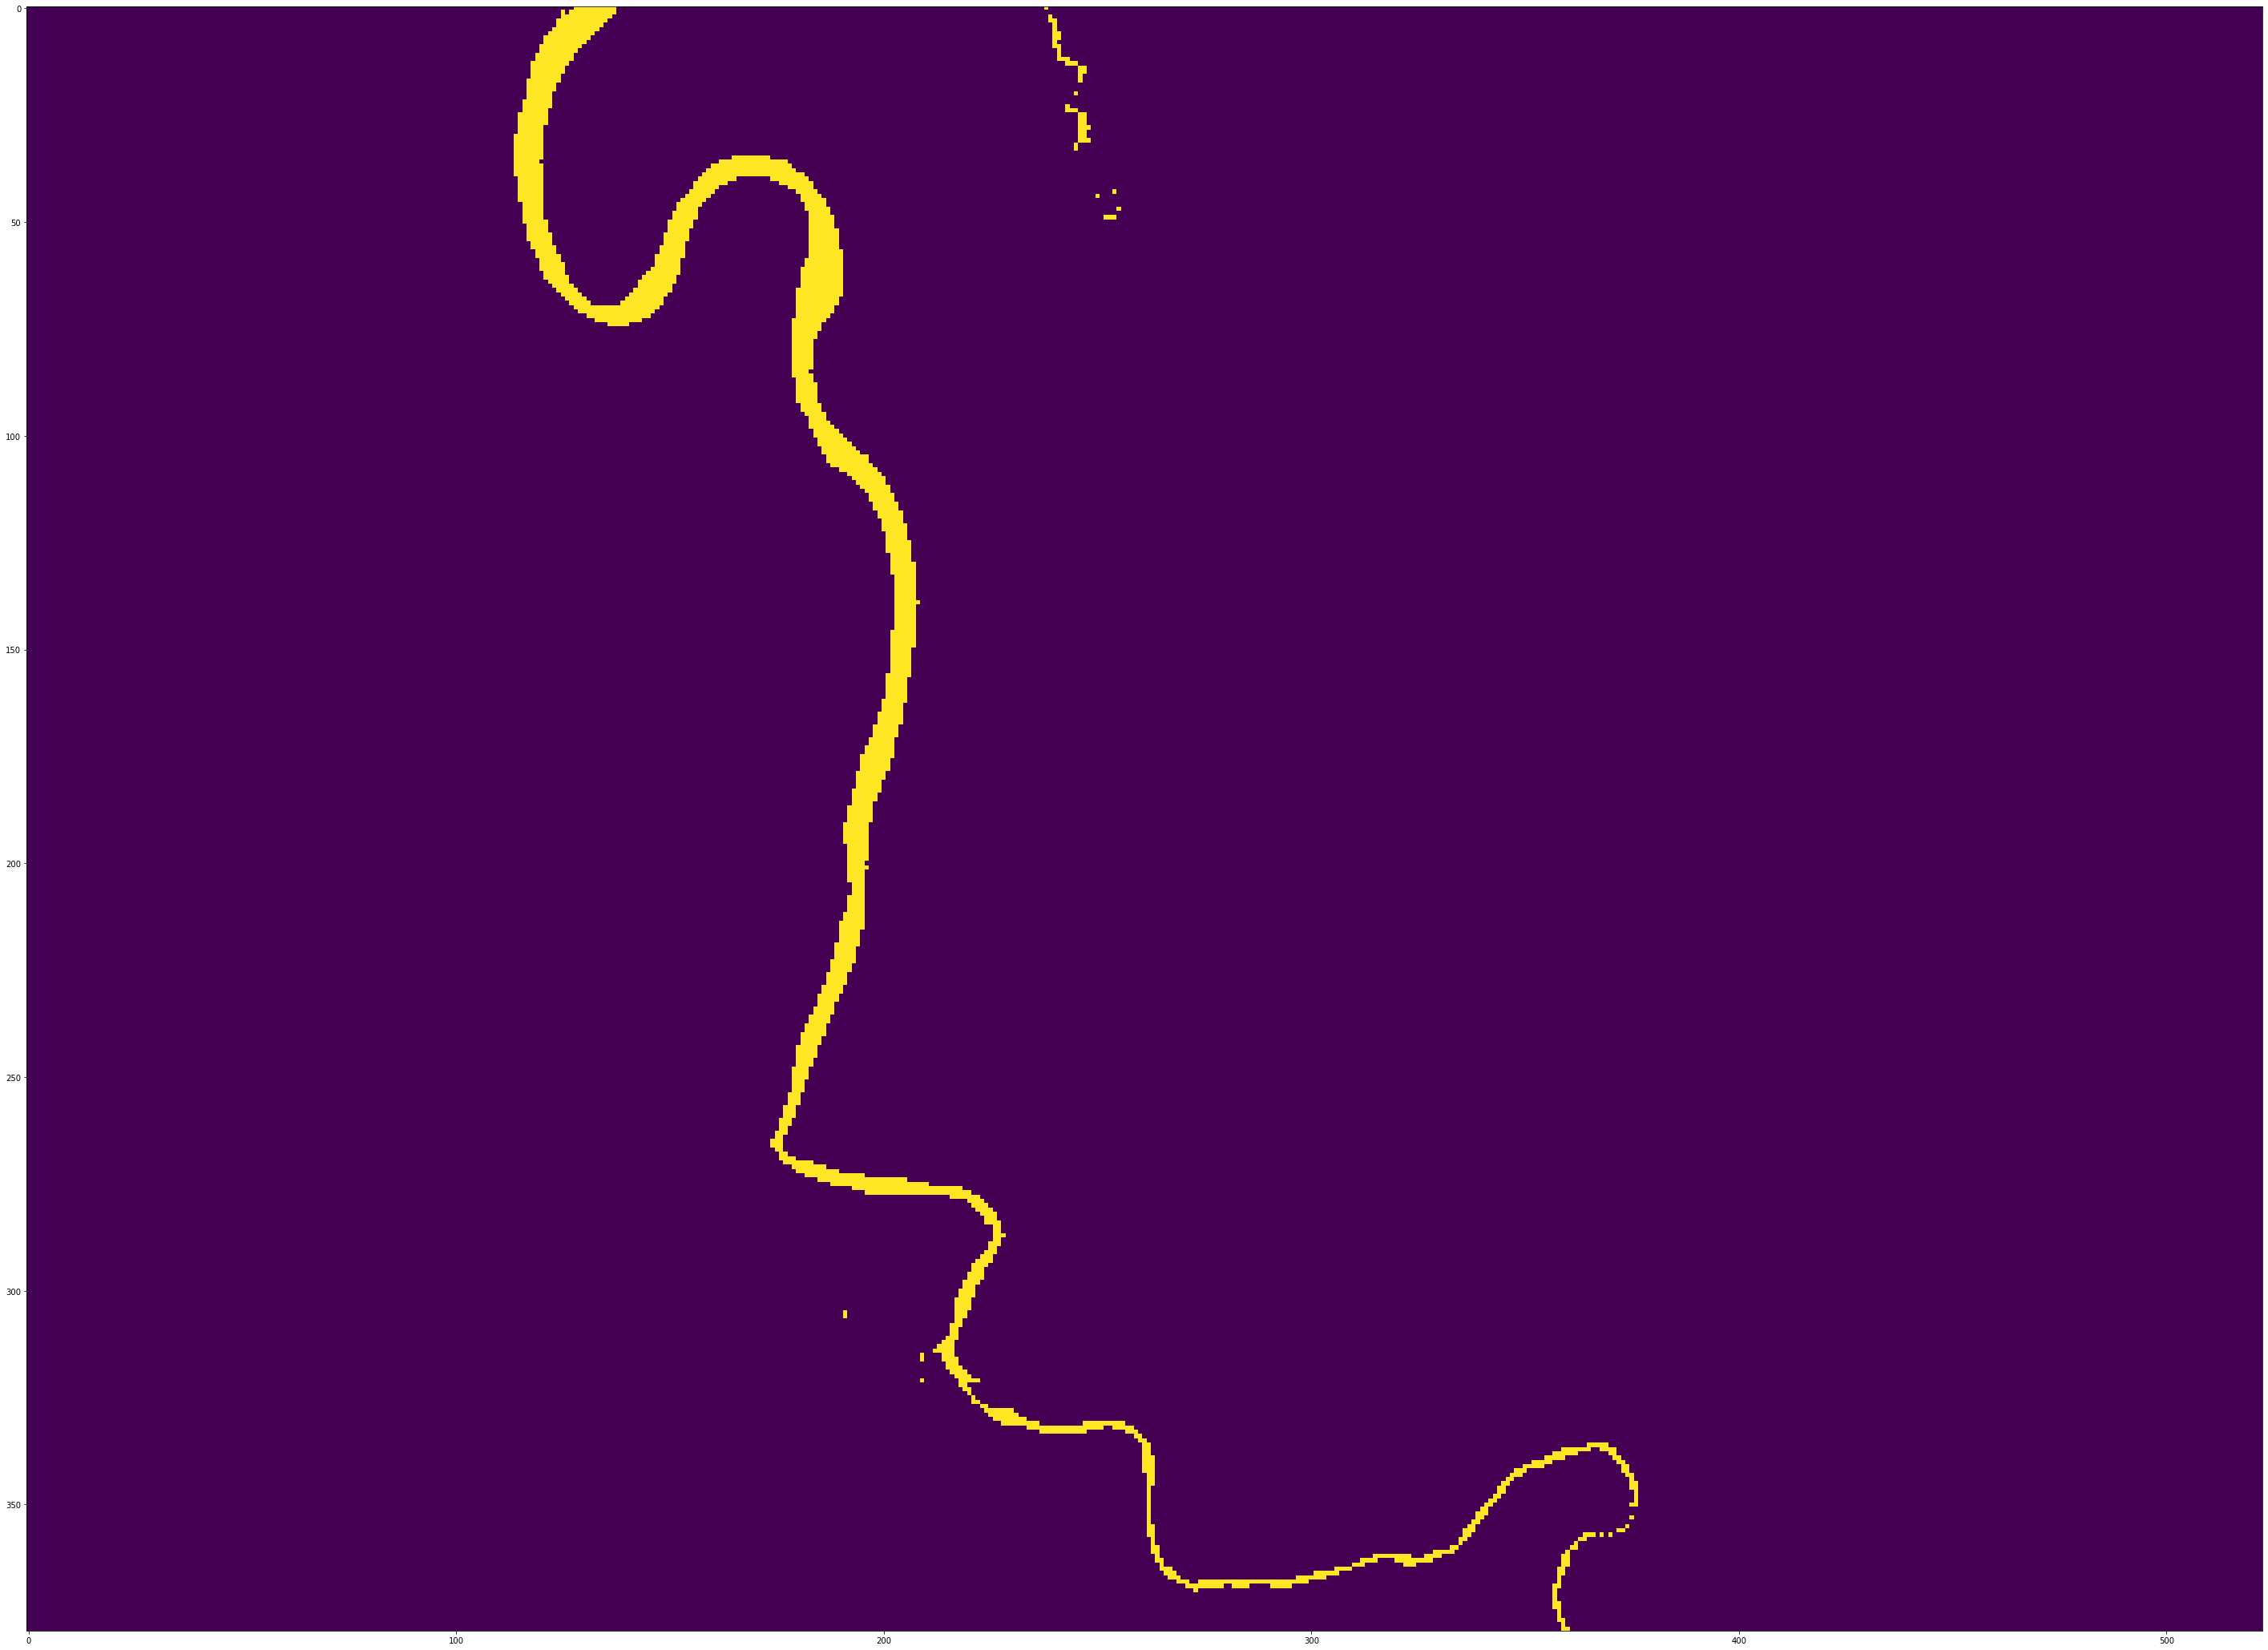

In [46]:
# jupyteronly
# plotting
# compute intermediary so we can plot it
wc_baseline_rc_comp = wc_baseline_rc.compute()
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_baseline_rc_comp)

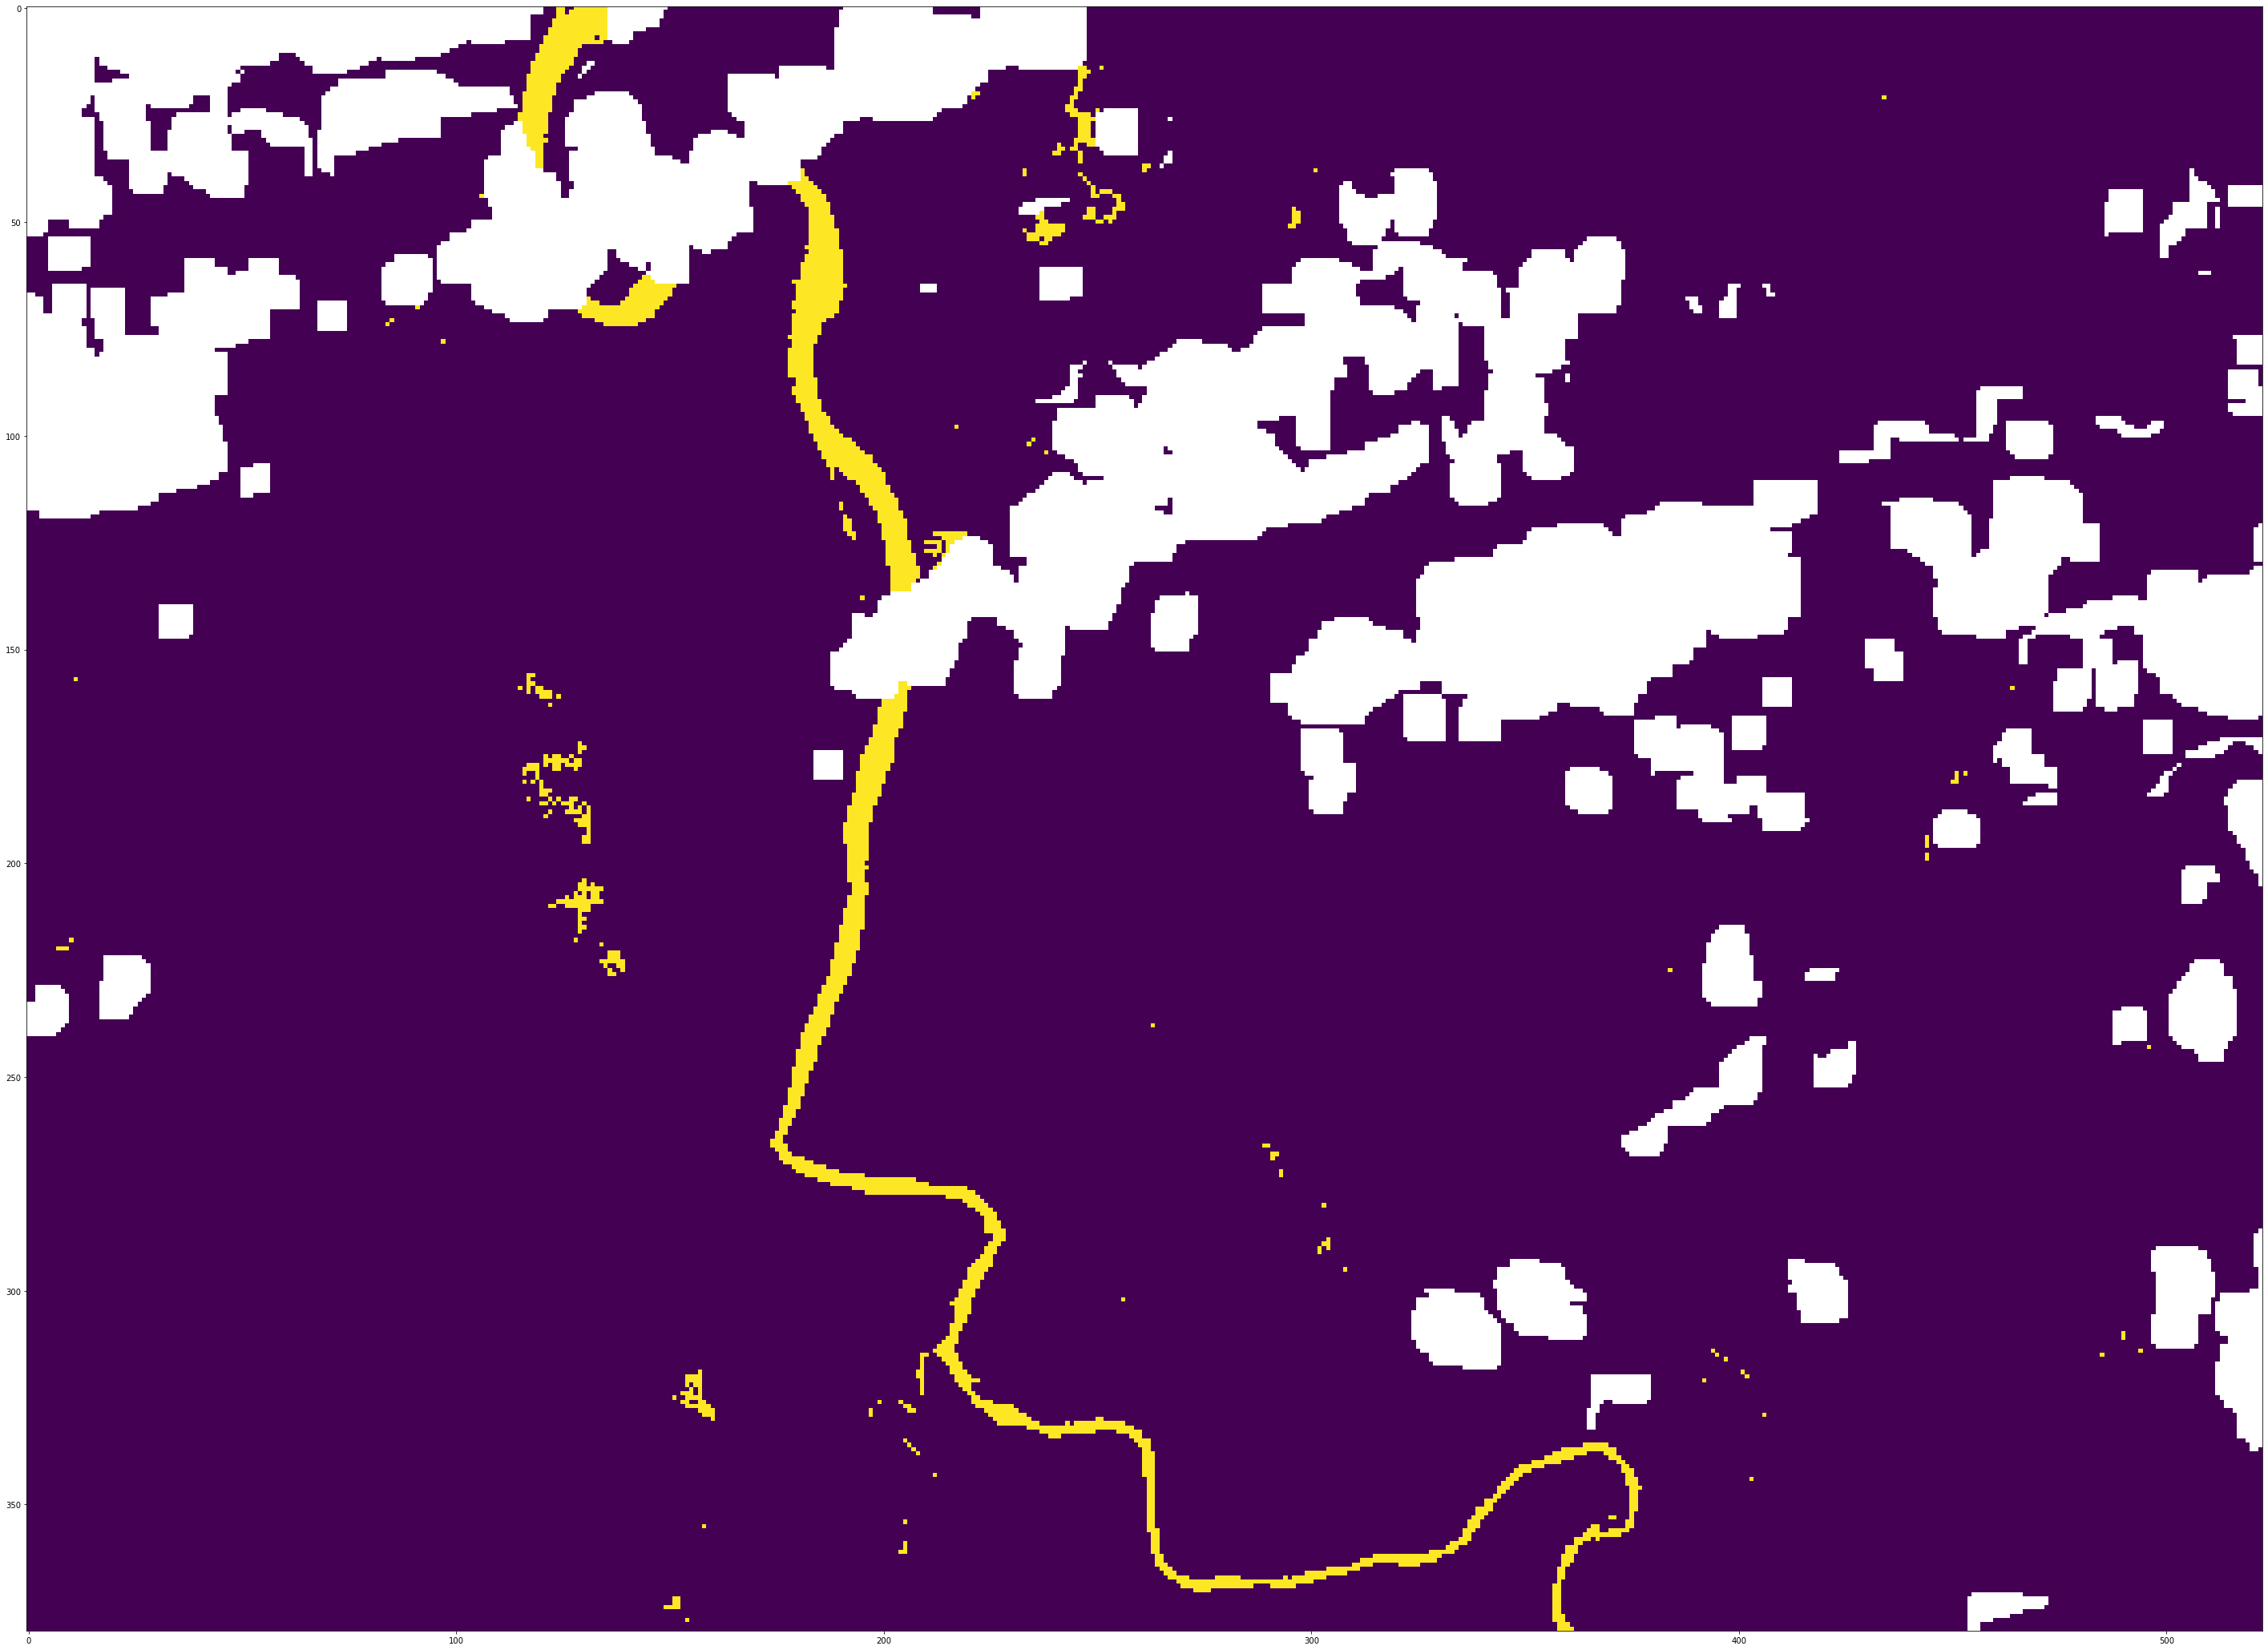

In [47]:
# jupyteronly
# compute intermediary so we can plot it
wc_analysis_rc_comp = wc_analysis_rc.compute()
fig, ax = plt.subplots(figsize=(50,50))
ax.imshow(wc_analysis_rc_comp)

In [48]:
### difference is one of the outputs we want.
difference = (wc_analysis_rc - wc_baseline_rc)

In [49]:
%%time
difference_thresh = difference.compute()

CPU times: user 272 ms, sys: 7.44 ms, total: 279 ms
Wall time: 3.14 s


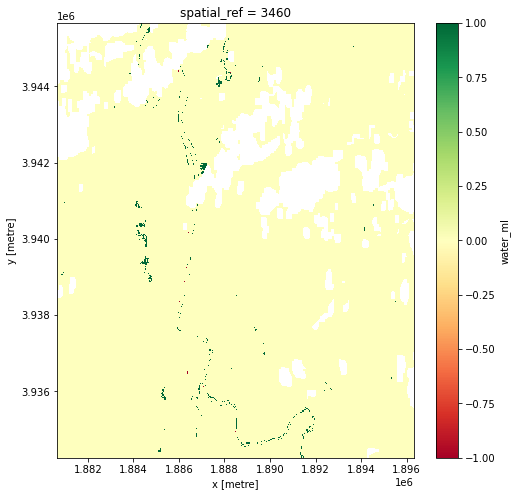

In [50]:
# jupyteronly
plt.figure(figsize = (8,8))
difference_thresh.plot(vmin=-1, vmax=1, cmap=RdYlGn)

### Export

In [51]:
#export range product as cog
write_cog(geo_im=difference_range,
          fname='WCRange.tif',
          overwrite=True)

PosixPath('WCRange.tif')

In [52]:
#export threshold product as cog
write_cog(geo_im=difference_thresh,
          fname='WCThres.tif',
          overwrite=True)

PosixPath('WCThres.tif')

In [53]:
#export as tifs
#write_geotiff_from_xr('difference_range.tiff', difference_range, crs=output_projection, x_coord = 'x', y_coord = 'y')
#write_geotiff_from_xr('difference_thresh.tiff', difference, crs=output_projection, x_coord = 'x', y_coord = 'y')

In [54]:
#naming exports for ESRI to pick up
['WCRange.tif', 'WCThres.tif' ]

['WCRange.tif', 'WCThres.tif']

---